In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import seaborn
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.porter import *
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

%matplotlib inline
%config IPCompleter.greedy=True

N_JOBS = 10

In [2]:
df = pd.read_csv('datasets/br/OffComBR3.arff.data', delimiter=';', names=['class', 'text'])

In [3]:
df.describe()

class
count  1033.000000
mean      0.195547
std       0.396813
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000

In [4]:
df.head()

class                                               text
0      1               Votaram no PEZAO Agora tomem no CZAO
1      0  cuidado com a poupanca pessoal Lembram o que a...
2      0  Sabe o que eu acho engracado os nossos governa...
3      0              Podiam retirar dos lucros dos bancos 
4      0  CADE O GALVAO PRA NARRAR AGORA   FALIIIIUUUUUU...

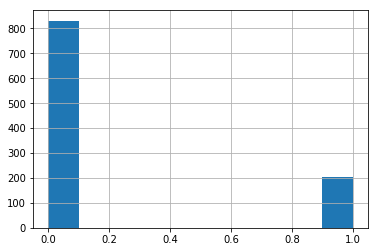

In [5]:
df['class'].hist();

In [6]:
df['class'][df['class']==1].shape

(202,)

# Replicação dos resultados
- Trabalho: Offensive Comments in the Brazilian Web: a dataset and baseline results

In [7]:
# stopwords = nltk.corpus.stopwords.words("portuguese")

DATA_FRAMES = {}

# parametros para construcao dos testes
params = (
    (False, 1, False, 'original_1G'),
    (False, 1, True, 'original_1G_FS'),
    (False, 2, False, 'original_1G_2G'),
    (False, 1, True, 'original_1G_2G_FS'),
    (False, 3, False, 'original_1G_2G_3G'),
    (False, 3, True, 'original_1G_2G_3G_FS'),
    (True, 1, False, 'lower_1G'),
    (True, 1, True, 'lower_1G_FS'),
    (True, 2, False, 'lower_1G_2G'),
    (True, 2, True, 'lower_1G_2G_FS'),
    (True, 3, False, 'lower_1G_2G_3G'),
    (True, 3, True, 'lower_1G_2G_3G_FS')
)

# quando use_fs é True
tree = DecisionTreeClassifier()

for is_lower, ngram_max, use_fs, df_name in params:
    vec = CountVectorizer(lowercase=is_lower, ngram_range=(1,ngram_max), token_pattern=r'(?u)\b\w+\b')
    matrix = vec.fit_transform(df['text'])
    names = np.array(vec.get_feature_names())
    dataframe = pd.DataFrame(matrix.toarray(), columns=names)
    
    if use_fs:
        sel = SelectFromModel(tree)
        fs = sel.fit_transform(dataframe, df['class'])
        indices = sel.get_support(True)
        
        dataframe = pd.DataFrame(fs, columns=names[indices])
        DATA_FRAMES[df_name] = dataframe
        
    else:
        DATA_FRAMES[df_name] = dataframe
        
        
    print(df_name, ' - ', dataframe.shape)
    

original_1G  -  (1033, 4347)
original_1G_FS  -  (1033, 148)
original_1G_2G  -  (1033, 15084)
original_1G_2G_FS  -  (1033, 148)
original_1G_2G_3G  -  (1033, 26599)
original_1G_2G_3G_FS  -  (1033, 151)
lower_1G  -  (1033, 3646)
lower_1G_FS  -  (1033, 146)
lower_1G_2G  -  (1033, 13881)
lower_1G_2G_FS  -  (1033, 150)
lower_1G_2G_3G  -  (1033, 25302)
lower_1G_2G_3G_FS  -  (1033, 147)


In [8]:
DATA_FRAMES['original_1G'].head()

A  ABAIXO  ACEFALA  ACEFALOSESTE  ACEITAREMOS  ACHO  ACOMODOU  ACORDA  \
0  0       0        0             0            0     0         0       0   
1  0       0        0             0            0     0         0       0   
2  0       0        0             0            0     0         0       0   
3  0       0        0             0            0     0         0       0   
4  0       0        0             0            0     0         0       0   

   ADESTRADOJOGA  ADRIANO  ...   zagueiro  zagueiros  ze  zeras  zero  zombe  \
0              0        0  ...          0          0   0      0     0      0   
1              0        0  ...          0          0   0      0     0      0   
2              0        0  ...          0          0   0      0     0      0   
3              0        0  ...          0          0   0      0     0      0   
4              0        0  ...          0          0   0      0     0      0   

   zona  zozoi  zuados  zuar  
0     0      0       0     0  
1     0      0       0     0  
2     0      0       0     0  
3     0      0       0     0  
4     0      0       0     0  

[5 rows x 4347 columns]

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, random_state=1)

y = df['class'].astype(float)

In [15]:
print('SVM=dict(')
svm = SVC(kernel='linear', C=1)

for name, x in DATA_FRAMES.items():
    f1 = cross_val_score(svm, x, y, cv=cv, scoring='f1_weighted', n_jobs=N_JOBS)
    print(f'{name}={list(f1)},')
print(')')


print('NB=dict(')
nb = GaussianNB()

for name, x in DATA_FRAMES.items():
    f1 = cross_val_score(nb, x, y, cv=cv, scoring='f1_weighted',  n_jobs=N_JOBS)
    print(f'{name}={list(f1)},')
print(')')

SVM=dict(
original_1G=[0.7777777777777778, 0.7636780159730979, 0.8231832892027064, 0.7365188146455994, 0.764618904140163, 0.7568770226537215, 0.8414969462491181, 0.815236902152029, 0.7786173083889006, 0.7575332425211768],
original_1G_FS=[0.784987616688893, 0.8136752136752137, 0.7746719300117358, 0.7678377943464034, 0.8245978798671753, 0.8629535718597955, 0.8629535718597955, 0.7997083822326541, 0.7610986640112853, 0.8087777733644286],
original_1G_2G=[0.7473118279569892, 0.7636780159730979, 0.7678377943464034, 0.7637843082737059, 0.7707615826956942, 0.7746719300117358, 0.8587105722339046, 0.8245978798671753, 0.7936854244261247, 0.737208530412414],
original_1G_2G_FS=[0.7591973244147155, 0.8126165341856976, 0.7997083822326541, 0.7849887976101568, 0.7936854244261247, 0.8087777733644286, 0.8629535718597955, 0.7997083822326541, 0.7433996674354986, 0.7637843082737059],
original_1G_2G_3G=[0.7275517321553127, 0.7449832775919732, 0.7746719300117358, 0.7478377409652633, 0.7849887976101568, 0.78162